<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeAutomatizado/blob/master/notebooks/4b_curva_roc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de documentos
En esta libreta veremos cómo evaluar clasificadores binarios y multiclase.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups

## Binario
Para el clasificador binario usaremos la curva ROC, por lo que definiremos una función que calcule la tasa de falsos positivos y otra que calcule la tasa de verdaderos positivos.

In [2]:
def radio_falsos_positivos(probabilities, thres):
  return np.mean(probabilities >= thres)

def radio_verdaderos_positivos(probabilities, thres):
  return np.mean(probabilities >= thres)

Usando estas funciones calcularemos los valores para la curva ROC

In [3]:
def roc(probabilities, y):
  positivos = np.where(y == 1)
  negativos = np.where(y == 0)

  rvps = np.zeros(np.unique(probabilities).shape[0])
  rfps = np.zeros(np.unique(probabilities).shape[0])
    
  for i, p in enumerate(np.unique(probabilities)[::-1]):
    rvps[i] = radio_verdaderos_positivos(probabilities[positivos], p)
    rfps[i] = radio_falsos_positivos(probabilities[negativos], p)

  return rvps, rfps

Definimos funciones para calcular el área bajo la curva ROC usando la [fórmula de Shoelace](https://en.wikipedia.org/wiki/Shoelace_formula)

In [4]:
def area_poligono(vertices):
  area = 0.0
  n_vert = len(vertices)
  for i in range(n_vert - 1):
    area = area + vertices[i][0] * vertices[i + 1][1]
    area = area - vertices[i + 1][0] * vertices[i][1]

  area = area + vertices[n_vert - 1][0] * vertices[0][1]
  area = area - vertices[0][0] * vertices[n_vert - 1][1]

  return 0.5 * abs(area)

def aucroc(tfp, tvp):
  auc = 0.0
  fprev = 0.0
  vprev = 0.0
  for i,(f,v) in enumerate(zip(tfp, tvp)):
    auc += area_poligono([[fprev, 0], [fprev, vprev], [f, v], [f, 0]])
    fprev = f
    vprev = v

  return auc

Descargamos los subconjuntos de entrenamiento y validación del conjunto de documentos _20 Newsgroups_ con los temas `alt.atheism` y `talk.religion.misc`.

In [5]:
categories = ['alt.atheism', 'talk.religion.misc']
remove = ('headers', 'footers', 'quotes')
ngbin_ent = fetch_20newsgroups(subset='train', categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)

ngbin_val = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)

Calculamos la representación de bolsa de palabras para cada subconjunto.

In [6]:
tfidf = TfidfVectorizer(sublinear_tf = True, max_df = 0.7,
                        stop_words = 'english')
X_ent = tfidf.fit_transform(ngbin_ent.data)
y_ent = ngbin_ent.target

X_val = tfidf.transform(ngbin_val.data)
y_val = ngbin_val.target

Instancia un clasificador de regresión logística entrenado mediante descenso por gradiente que discrimine entre documentos de estos 2 temas.

In [7]:
m = LogisticRegression()
m = m.fit(X_ent, y_ent)

Obtenemos las predicciones (probabilidades) de los ejemplos del subconjunto de validación.

In [8]:
prob = m.predict_proba(X_val)[:,1]

Calculamos los radios de verdaderos positivos y de falsos positivos para cada umbral.

In [9]:
rvps, rfps = roc(prob, y_val)

Graficamos la curva ROC

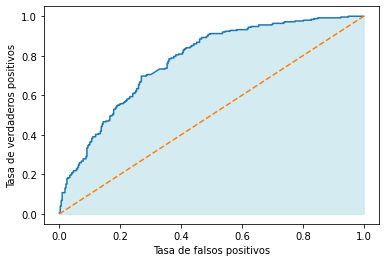

In [10]:
plt.plot(rfps, rvps)
plt.plot([0, 1], [0, 1], '--')
plt.fill_between(rfps, rvps, 0, alpha=0.5, color = 'lightblue')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.show()

Calculamos su area bajo la curva

In [11]:
aucroc(rfps, rvps)

0.7742134908641312

Esta función es equivalente a `roc_auc_score` de scikit-learn

In [12]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, prob)

0.7742134908641297